In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from step import preprocessing as pp
from step import stats as st
from step import util
from step.model import step
from step.model import utility

from rdflib import Namespace, Graph

import gpxpy
import pandas as pnd
import numpy as np
from datetime import timedelta
from tabulate import tabulate
import folium

from scipy import stats

from sklearn import preprocessing

from math import cos, radians

import ipympl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%load_ext autoreload
%autoreload 2

%matplotlib notebook
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['ytick.labelsize'] = 'medium'
matplotlib.rcParams['xtick.labelsize'] = 'medium'
matplotlib.rcParams['figure.figsize'] = (9, 6)
#matplotlib.rcParams['axes.xmargin'] = 0.1
#matplotlib.rcParams['axes.ymargin'] = 0.1
sns.set_style('ticks', {"axes.xmargin": 0.2, "axes.ymargin": 0.2});

INFO:rdflib:RDFLib Version: 4.2.1


In [2]:
file = 'run_grenoble.csv'
#file = 'run_barcelona.csv'
trajectories = pnd.read_csv(file, index_col=0, parse_dates=True)
#path = r"C:\Users\Tales\Desktop\user54594328_traj1001316367.csv"
#df = pnd.read_csv(path, parse_dates=True, index_col='timestamp')

In [3]:
_1 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\950590555.gpx'
_2 = r'C:\DATA\MapMyRun\Grenoble\37695677\16_16_Run _ Jog\1007756961.gpx'
_3 = r'C:\DATA\MapMyRun\Grenoble\49996348\16_16_Run _ Jog\1079694145.gpx'
_4 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1223879101.gpx'
_7 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\728010151.gpx'
_25 = r'C:\DATA\MapMyRun\Barcelona\54155702\16_103_Sprints\835097087.gpx'
_14 = r'C:\DATA\MapMyRun\Barcelona\54594328\16_16_Run _ Jog\1001316367.gpx'
_31 = r'C:\DATA\MapMyRun\Barcelona\40597477\16_16_Run _ Jog\1100430165.gpx'
_32 = r'C:\DATA\MapMyRun\Grenoble\38534723\16_16_Run _ Jog\998898403.gpx'
_33 = r'C:\DATA\MapMyRun\Grenoble\27031614\11_637_Commute\1583713025.gpx'
_34 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\1416690011.gpx'
_36 = r'C:\DATA\MapMyRun\Grenoble\9909216\16_16_Run _ Jog\709085461.gpx' #direction outliers
_37 = r'C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\1145927101.gpx'
_38 = r'C:\DATA\MapMyRun\Grenoble\41837719\16_16_Run _ Jog\1326019061.gpx'
_39 = r'C:\DATA\MapMyRun\Grenoble\38534723\16_16_Run _ Jog\1146478373.gpx'

_40 = r'C:\DATA\MapMyRun\Chicago\22732467\16_16_Run _ Jog\1086077661.gpx' #no distance outlier, sequence of 'stops'
_41 = r'C:\DATA\MapMyRun\Chicago\35494281\16_16_Run _ Jog\995057635.gpx' #no outliers
_42 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\1386845507.gpx'
_43 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_283_Easy _ General\1189007197.gpx' #no outliers
_44 = r'C:\DATA\MapMyRun\Grenoble\27031614\16_16_Run _ Jog\1389862259.gpx' #more than 50% of times are equal -> jitter
_45 = r'C:\DATA\MapMyRun\Grenoble\41837719\16_16_Run _ Jog\1758229736.gpx'

random = trajectories.sample(1)['path'].values[0]
print(random)

C:\DATA\MapMyRun\Grenoble\40890583\16_16_Run _ Jog\905333929.gpx


In [4]:
gpx = gpxpy.parse(open(_33, 'r'))
#Ignore first 30 seconds (to avoid GPS "time to first fix")
gpx = pp.discard(gpx, timedelta(seconds=30))

movement_attributes = pp.get_movement_attributes(gpx)
df_all = pnd.DataFrame(movement_attributes, index=movement_attributes['timestamp'])

df = df_all[1:]

i_series = pnd.Series(np.arange(len(df)), index=df.index).rename('idx')
df = pnd.concat([df, i_series], axis=1)

df.head(5)

,acceleration,angle,distance,elevation,heading,latitude,longitude,speed,time,timestamp,idx
2016-07-04 16:09:31,-0.006848,174.095079,10.563061,214,303,45.189825,5.766500,2.112613,5,2016-07-04 16:09:31,0
2016-07-04 16:09:36,-0.029138,172.894389,10.391864,214,297,45.189868,5.766382,2.078374,5,2016-07-04 16:09:36,1
2016-07-04 16:09:42,-0.051880,168.078235,11.421273,214,290,45.189903,5.766245,1.903547,6,2016-07-04 16:09:42,2
2016-07-04 16:09:49,0.006383,179.957598,10.782701,214,302,45.189955,5.766128,1.540387,7,2016-07-04 16:09:49,3
2016-07-04 16:09:56,0.031547,177.258132,11.095481,215,302,45.190008,5.766008,1.585070,7,2016-07-04 16:09:56,4


In [5]:
points_data = gpx.get_points_data()
points = [(pdata.point.latitude, pdata.point.longitude) for pdata in points_data]

In [6]:
tileset = r'http://{s}.tile.openstreetmap.se/hydda/full/{z}/{x}/{y}.png'
attribution = 'Tiles courtesy of <a href="http://openstreetmap.se/" target="_blank">OpenStreetMap Sweden</a> \
                &mdash; Map data &copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>'

_map = folium.Map(tiles=tileset, attr=attribution, max_zoom=25)

start_mark = folium.Marker([points[0][0], points[0][1]], icon=folium.Icon(color='green', icon='glyphicon glyphicon-play'))
start_mark.add_to(_map)

end_mark = folium.Marker([points[-1][0], points[-1][1]], icon=folium.Icon(color='red', icon='glyphicon glyphicon-stop'))
end_mark.add_to(_map)

line = folium.PolyLine(points, opacity=0.8)
line.add_to(_map)
_map.fit_bounds(line.get_bounds())

_map

<IPython.core.display.Javascript object>


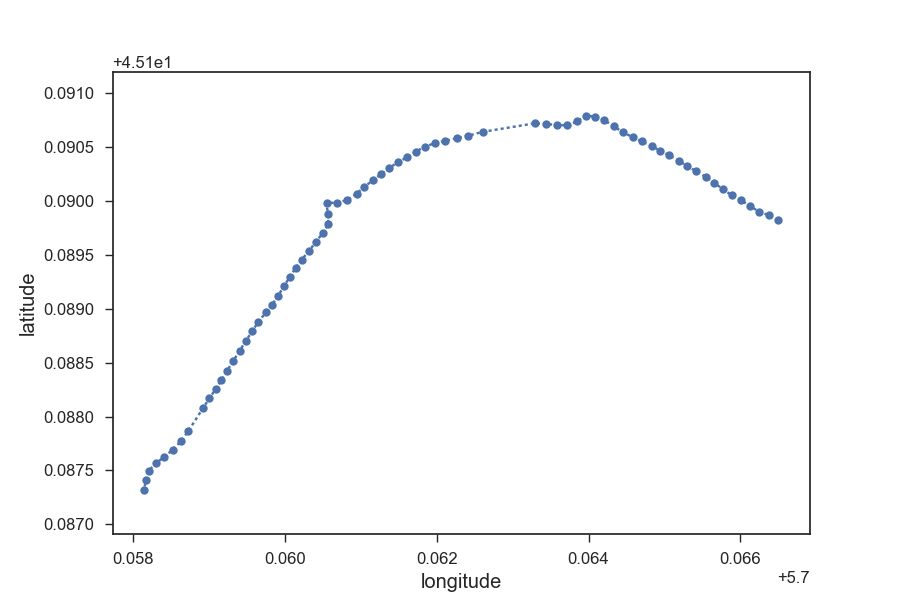

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

xx = df.longitude
yy = df.latitude

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.plot(df.longitude, df.latitude, 'o:', ms=6)
#plt.scatter(df.longitude, df.latitude, s=50, c=df.speed, cmap=cm.magma_r)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

<IPython.core.display.Javascript object>


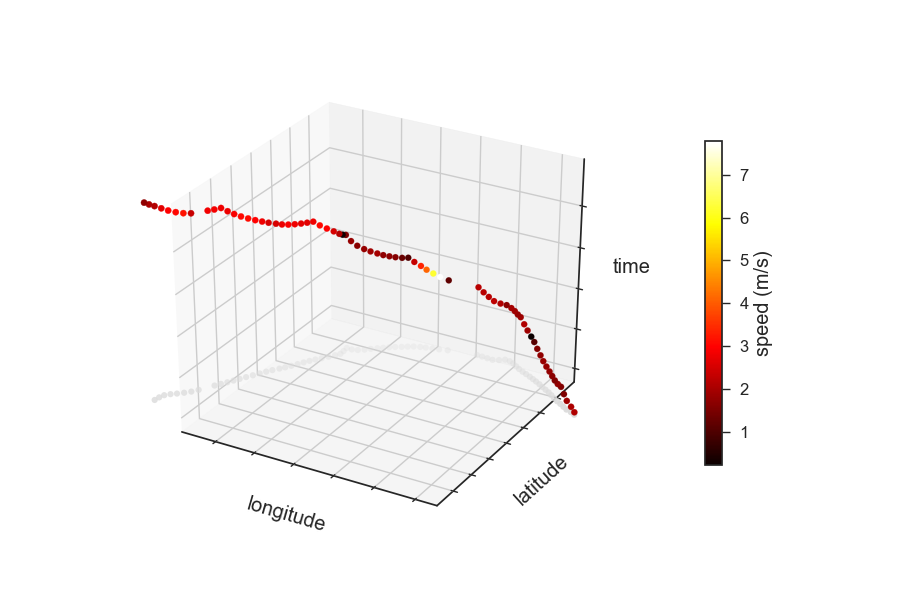

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.longitude, df.latitude, zs=0, c='gainsboro', depthshade=True, linewidth=0)
seconds = df['timestamp'].dt.second.cumsum()
#ax.plot(df.longitude, df.latitude, seconds, 'o:', ms=5);
scatter = ax.scatter(df.longitude, df.latitude, seconds, c=df.speed, depthshade=True, cmap=cm.hot, 
                     edgecolors='face', label='speed');

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('time')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

central_latitude = sum(ax.get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
ax.set_aspect(mercator_aspect_ratio, adjustable='datalim')

fig.colorbar(scatter, label='speed (m/s)', pad=.1, shrink=.7);

<IPython.core.display.Javascript object>


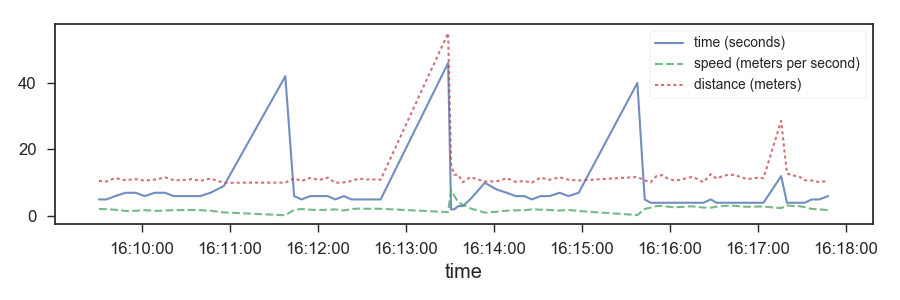

In [9]:
fig = plt.figure(figsize=(9,3))
plt.plot(df['time'], '-', label='time (seconds)', lw=1.5, ms=7, mew=.5, mec='k', alpha=.8)
plt.plot(df['speed'], '--', label='speed (meters per second)', lw=1.5, ms=7, mew=.5, mec='k', alpha=.8)
plt.plot(df['distance'], ':', label='distance (meters)', lw=1.5, ms=7, mew=.5, mec='k', alpha=.8)

plt.gca().xaxis.zoom(-0.1)
plt.xlabel("time")

plt.legend(loc='best', frameon=True);
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.tight_layout()
#plt.savefig('figures/msn-speed-time-distance.png')

<IPython.core.display.Javascript object>


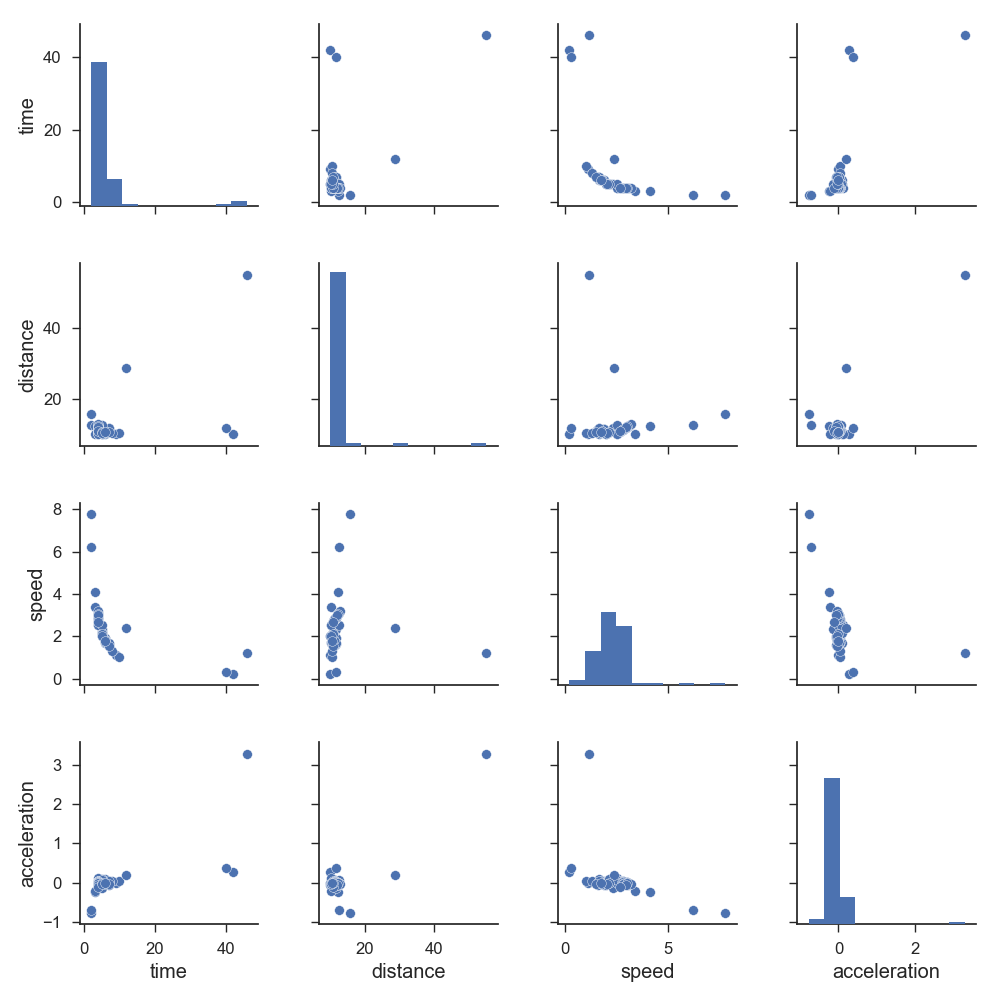

In [10]:
#size=3 for higher resolution
sns.pairplot(df[['time', 'distance', 'speed', 'acceleration']]);
plt.tight_layout()

## _modified z-score_

## Noise labeling

In [11]:
distance_threshold = 3.5
speed_threshold = 3.5
time_threshold = 5
jitter = 0.5

### Distance

In [12]:
dist = df['distance']

mz_dist = st.modified_zscore(dist)

dist_outlier_indexes = [i for i, mz in enumerate(mz_dist) if abs(mz) > distance_threshold]
long_dist_indexes = [i for i, mz in enumerate(mz_dist) if mz > distance_threshold]

outliers_dist = df.iloc[long_dist_indexes]
print(dist.describe())
print(len(long_dist_indexes))
print(tabulate(outliers_dist[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

count    74.000000
mean     12.001508
std       5.520848
min       9.985563
25%      10.599752
50%      11.091175
75%      11.641119
max      54.960081
Name: distance, dtype: float64
3
+---------------------+-------+--------+------------+---------+
|                     |   idx |   time |   distance |   speed |
|---------------------+-------+--------+------------+---------|
| 2016-07-04 16:13:29 |    27 |     46 |    54.9601 | 1.19478 |
| 2016-07-04 16:13:31 |    28 |      2 |    15.5535 | 7.77674 |
| 2016-07-04 16:17:16 |    66 |     12 |    28.6166 | 2.38471 |
+---------------------+-------+--------+------------+---------+


In [13]:
long_distances_i = [i for i, mz in enumerate(mz_dist) if mz > distance_threshold]
print(long_distances_i)

[27, 28, 66]


<IPython.core.display.Javascript object>


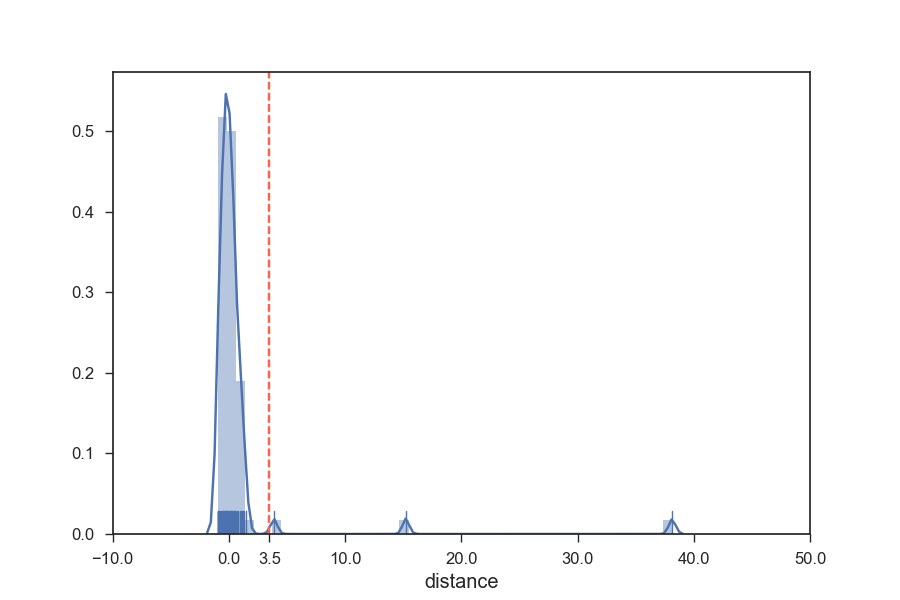

C:\Users\Tales\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [14]:
plt.figure()
sns.distplot(mz_dist, rug=True);

plt.xticks(list(plt.xticks()[0]) + [distance_threshold])
plt.axvline(distance_threshold, color='tomato', linestyle='--');
#plt.savefig('figures/msn-mz-distance.png')

<IPython.core.display.Javascript object>


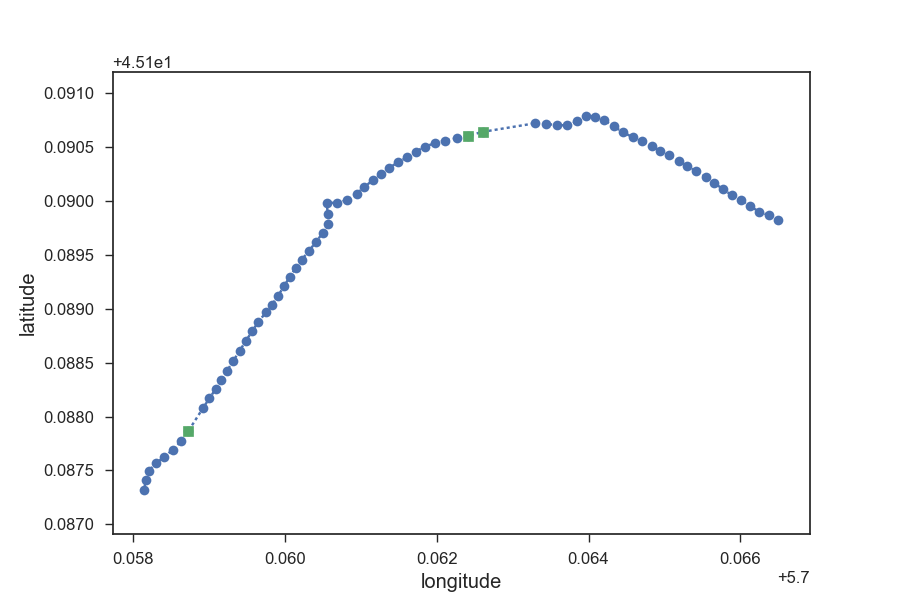

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', ms=7)

xx_dist = df.iloc[long_distances_i]['longitude']
yy_dist = df.iloc[long_distances_i]['latitude']
plt.plot(xx_dist, yy_dist, 's', ms=7, mew=.5)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')
#plt.savefig('figures/msn-map-distance.png')

### Direction

In [16]:
min_direction_threshold = 45
max_sequential_sharp_angles = 1

In [17]:
sharp_angles = df[df['angle'] < min_direction_threshold][:-1] #[0:-1] because the last angle is always equal to zero
sharp_angles_i = [df.index.get_loc(i) for i in sharp_angles.index]

diff = np.ediff1d(sharp_angles_i, np.inf)
mask = [True if d <= max_sequential_sharp_angles + 1 else False for d in diff]

direction_outliers = []
for i, m in enumerate(mask):
    if m:
        direction_outliers.append(sharp_angles_i[i])
        direction_outliers.append(sharp_angles_i[i+1])
        
direction_intervals = util.get_interval_limits(direction_outliers)

direction_i = []
for interval in direction_intervals:
    direction_i.extend(np.linspace(interval[0], interval[1], interval[1]-interval[0]+1, dtype=int))
    
direction_i

[]

<IPython.core.display.Javascript object>


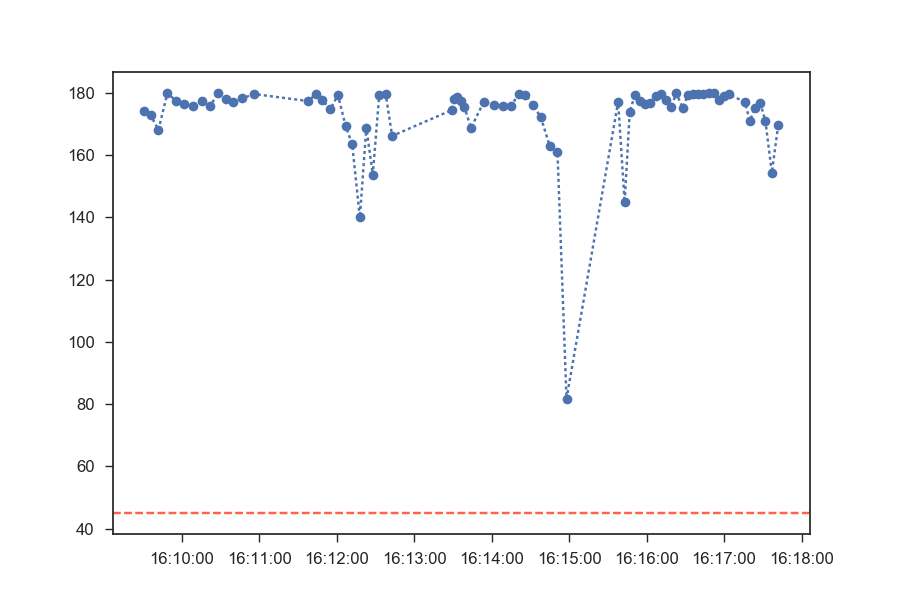

In [18]:
plt.figure()
plt.plot(df['angle'][:-1], ':o')
plt.plot(df.iloc[direction_i]['angle'], 's', color='tomato')
plt.axhline(min_direction_threshold, color='tomato', ls='--')
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M:%S"));
plt.savefig('figures/msn-sharp-angles.png')

<IPython.core.display.Javascript object>


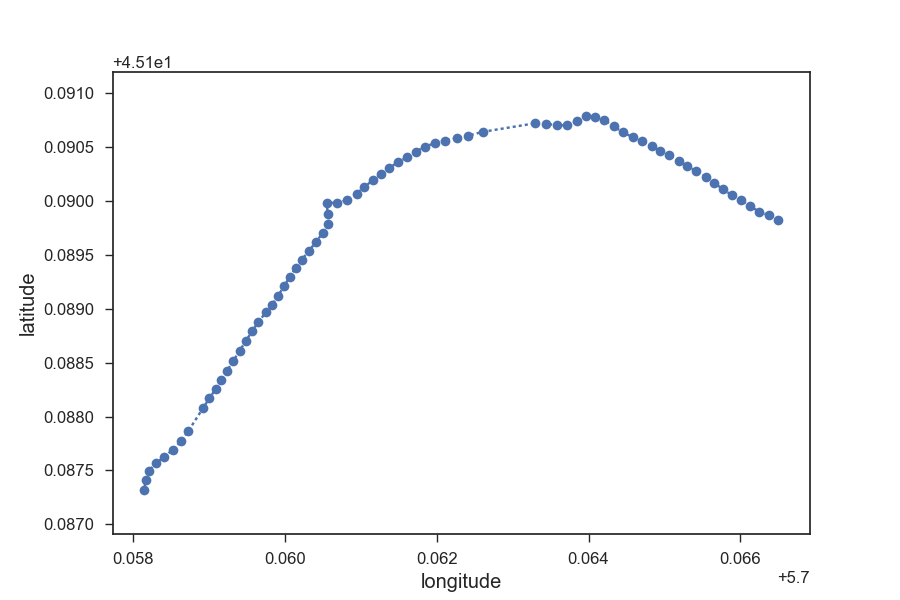

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', ms=7)

xx_dist = df.iloc[direction_i]['longitude']
yy_dist = df.iloc[direction_i]['latitude']
plt.plot(xx_dist, yy_dist, 's', ms=7, mew=.5)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

### Remove outliers

In [20]:
long_distances_i

[27, 28, 66]

In [21]:
direction_i

[]

In [22]:
out = np.union1d(long_distances_i, direction_i)
out = np.array(out, dtype=int)
outlier_intervals = util.get_interval_limits(out)

out = np.array([])
for interval in outlier_intervals:
    linspace = np.linspace(interval[0], interval[1], interval[1]-interval[0]+1)
    out = np.concatenate((out, linspace))
    
out = np.array(np.sort(out), dtype=int)
out

array([27, 28, 66])

In [23]:
df2 = df.drop(df.index[out])

original_len = len(df)
without_outliers_len = len(df2)

print('original:', original_len)
print('without outliers:', without_outliers_len)
print('{:.2f}% of points have been dropped'.format((1 - without_outliers_len/original_len)*100))

original: 74
without outliers: 71
4.05% of points have been dropped


<IPython.core.display.Javascript object>


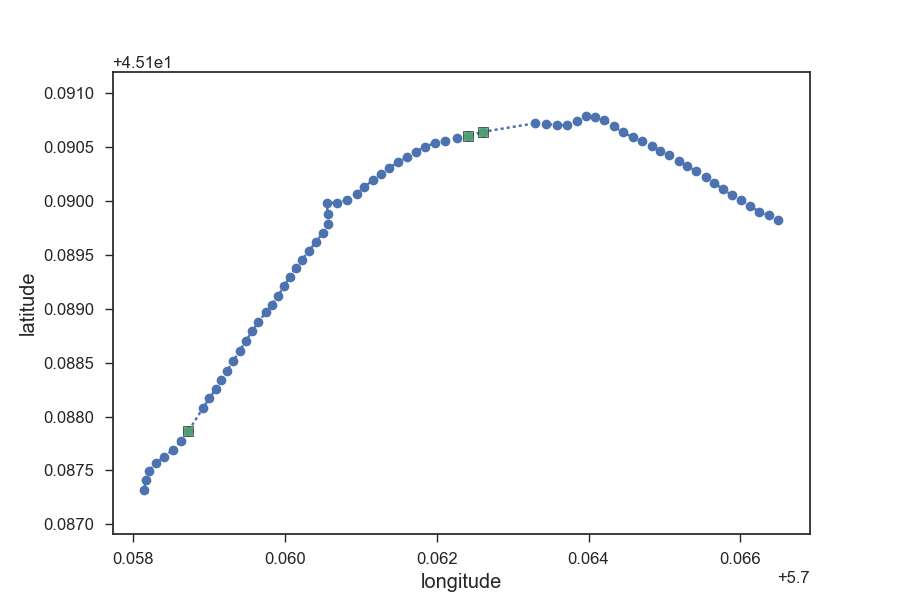

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', ms=7, alpha=1)

xx = df.iloc[out].longitude
yy = df.iloc[out].latitude
plt.plot(xx, yy, 's', ms=7, alpha=.8, mew=.5, mec='k')

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

## Time x Distance

<IPython.core.display.Javascript object>


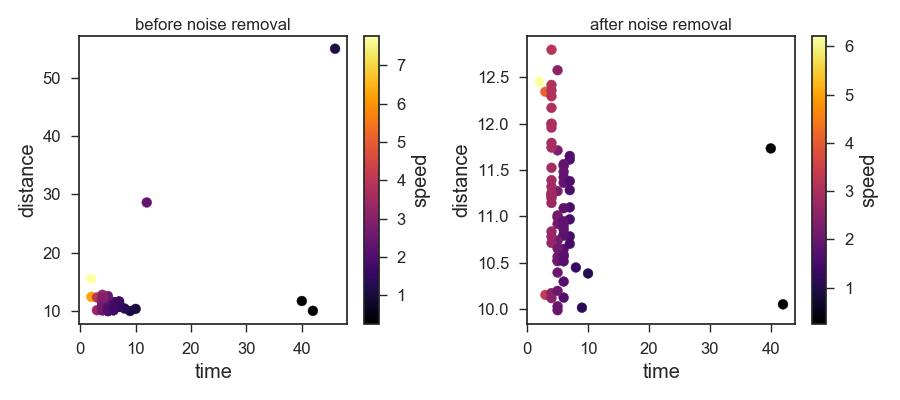

In [25]:
fig = plt.figure(figsize=(9,4))

ax = fig.add_subplot(121)
plt.title('before noise removal')
df.plot(x='time', y='distance', kind='scatter', c='speed', s=50, cmap=cm.inferno, ax=ax)

ax = fig.add_subplot(122)
plt.title('after noise removal')
df2.plot(x='time', y='distance', kind='scatter', c='speed', s=50, cmap=cm.inferno, ax=ax)

plt.tight_layout()

### Time

In [26]:
j_time = pp.jitter(df2['time'], jitter)
#log_j_time = np.log(j_time)
mz_time = st.modified_zscore(j_time)

time_outlier_indexes = [i for i, mz in enumerate(mz_time) if abs(mz) > time_threshold]
long_time_indexes = [i for i, mz in enumerate(mz_time) if mz > time_threshold]

outliers_time = df2.iloc[long_time_indexes]
print(j_time.describe())
print(len(outliers_time))
print(tabulate(outliers_time[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

count    71.000000
mean      6.216520
std       6.069917
min       1.540837
25%       4.264912
50%       5.070596
75%       6.169011
max      41.623833
Name: time, dtype: float64
2
+---------------------+-------+--------+------------+----------+
|                     |   idx |   time |   distance |    speed |
|---------------------+-------+--------+------------+----------|
| 2016-07-04 16:11:38 |    14 |     42 |    10.049  | 0.239262 |
| 2016-07-04 16:15:38 |    44 |     40 |    11.7319 | 0.293297 |
+---------------------+-------+--------+------------+----------+


<IPython.core.display.Javascript object>


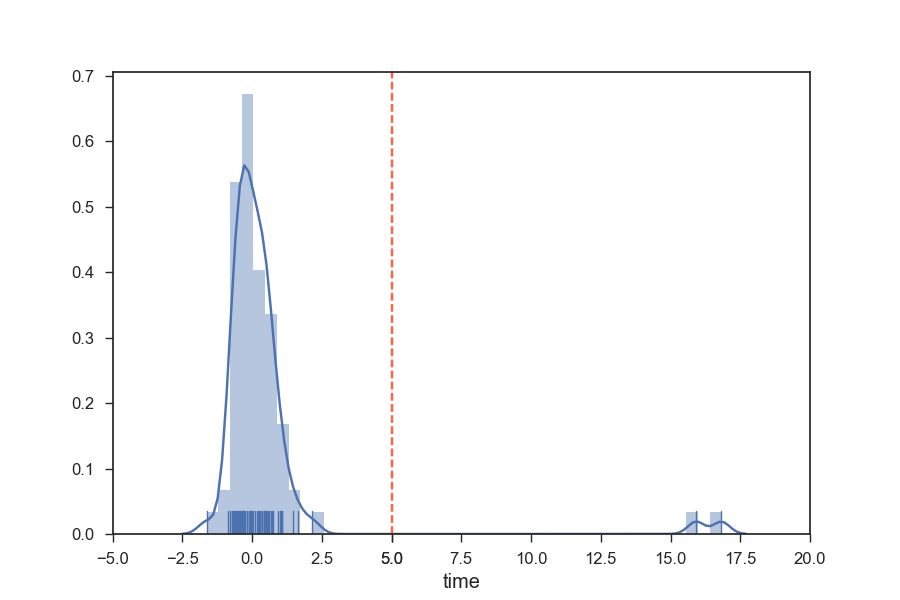

C:\Users\Tales\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [27]:
plt.figure()
sns.distplot(mz_time, rug=True)
plt.xticks(list(plt.xticks()[0]) + [time_threshold])
plt.axvline(time_threshold, color='tomato', linestyle='--');
#plt.axvline(-time_threshold, color='tomato', linestyle='--');
#plt.savefig('figures/msn-mz-time.png')

### Speed

<IPython.core.display.Javascript object>


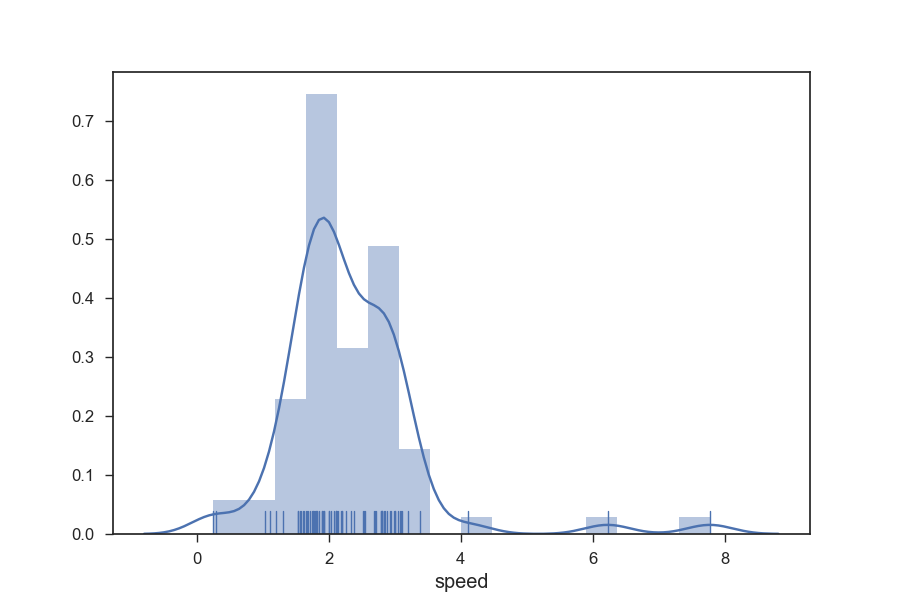

C:\Users\Tales\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [28]:
plt.figure()
sns.distplot(df.speed, rug=True)

plt.savefig('figures/msn-speed-original.png')

In [29]:
df2.speed.describe()

count    71.000000
mean      2.252417
std       0.834828
min       0.239262
25%       1.769201
50%       2.104269
75%       2.806642
max       6.225895
Name: speed, dtype: float64

In [30]:
log_speed = np.log(df2['speed'])
mz_speed = st.modified_zscore(log_speed).rename('mz_speed')
#mz_speed = mz_speed.rename('mz_speed')

speed_outlier_indexes = [i for i, mz in enumerate(mz_speed) if abs(mz) > speed_threshold]
slowest_speed_indexes = [i for i, mz in enumerate(mz_speed) if mz < -speed_threshold]

outliers_speed = df2.iloc[slowest_speed_indexes]
print(len(outliers_speed))
print(tabulate(outliers_speed[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

2
+---------------------+-------+--------+------------+----------+
|                     |   idx |   time |   distance |    speed |
|---------------------+-------+--------+------------+----------|
| 2016-07-04 16:11:38 |    14 |     42 |    10.049  | 0.239262 |
| 2016-07-04 16:15:38 |    44 |     40 |    11.7319 | 0.293297 |
+---------------------+-------+--------+------------+----------+


<IPython.core.display.Javascript object>


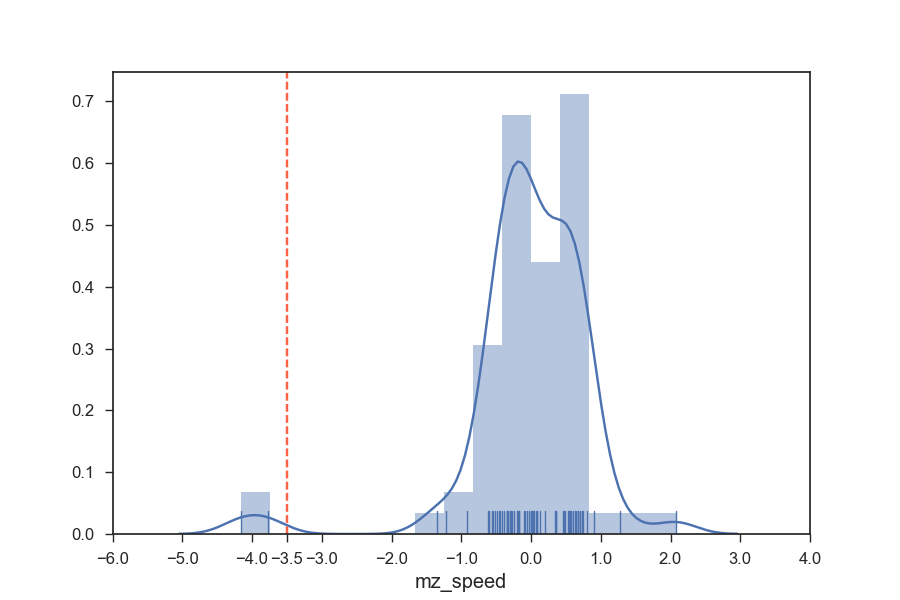

C:\Users\Tales\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [31]:
plt.figure()
sns.distplot(mz_speed, rug=True)

plt.xticks(list(plt.xticks()[0]) + [-speed_threshold])
plt.axvline(-speed_threshold, color='tomato', linestyle='--');
plt.savefig('figures/msn-speed-log.png')

In [32]:
print('distance', len(outliers_dist))
print(tabulate(outliers_dist[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

print('time', len(outliers_time))
print(tabulate(outliers_time[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

print('speed', len(outliers_speed))
print(tabulate(outliers_speed[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

speed_time_intersection = outliers_time.merge(outliers_speed).set_index('timestamp')

print('speed_time_intersection', len(speed_time_intersection))
print(tabulate(speed_time_intersection[['idx', 'time', 'distance', 'speed']], headers='keys', tablefmt='psql'))

distance 3
+---------------------+-------+--------+------------+---------+
|                     |   idx |   time |   distance |   speed |
|---------------------+-------+--------+------------+---------|
| 2016-07-04 16:13:29 |    27 |     46 |    54.9601 | 1.19478 |
| 2016-07-04 16:13:31 |    28 |      2 |    15.5535 | 7.77674 |
| 2016-07-04 16:17:16 |    66 |     12 |    28.6166 | 2.38471 |
+---------------------+-------+--------+------------+---------+
time 2
+---------------------+-------+--------+------------+----------+
|                     |   idx |   time |   distance |    speed |
|---------------------+-------+--------+------------+----------|
| 2016-07-04 16:11:38 |    14 |     42 |    10.049  | 0.239262 |
| 2016-07-04 16:15:38 |    44 |     40 |    11.7319 | 0.293297 |
+---------------------+-------+--------+------------+----------+
speed 2
+---------------------+-------+--------+------------+----------+
|                     |   idx |   time |   distance |    speed |
|-----

In [33]:
stop_i = speed_time_intersection['idx'].values
stop_i

array([14, 44])

In [34]:
q = 'idx in {}'.format(list(stop_i))
df.query(q)

,acceleration,angle,distance,elevation,heading,latitude,longitude,speed,time,timestamp,idx
2016-07-04 16:11:38,0.275688,177.366736,10.049018,216,298,45.190511,5.764833,0.239262,42,2016-07-04 16:11:38,14
2016-07-04 16:15:38,0.370802,177.174237,11.731872,213,174,45.189882,5.760566,0.293297,40,2016-07-04 16:15:38,44


<IPython.core.display.Javascript object>


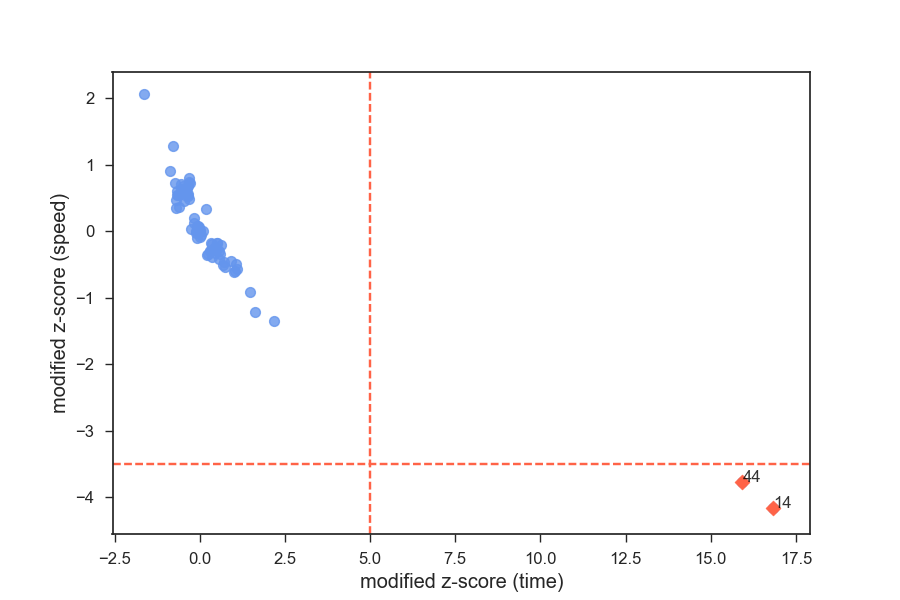

C:\Users\Tales\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:546: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [35]:
x_label = 'modified z-score (time)'
y_label = 'modified z-score (speed)'

x = mz_time
y = mz_speed
X = np.stack((x, y), axis=-1)

fig = plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
ax = fig.add_subplot(111)
plt.scatter(X[:,0], X[:,1], s=50, alpha=.8, color='cornflowerblue', lw=1)
plt.axhline(-speed_threshold, color='tomato', linestyle='--')
plt.axvline(time_threshold, color='tomato', linestyle='--')
plt.legend(frameon=True)

for i, element in enumerate(X):
    if x[i] > time_threshold and y[i] < -speed_threshold:
        ax.annotate(df2.iloc[i]['idx'], xy=(element[0]+0.008, element[1]+0.001), color='black', alpha=.8)
        plt.scatter(element[0], element[1], marker='D', s=60, color='tomato')
        
plt.savefig('figures/msn-speed-time.png')

<IPython.core.display.Javascript object>


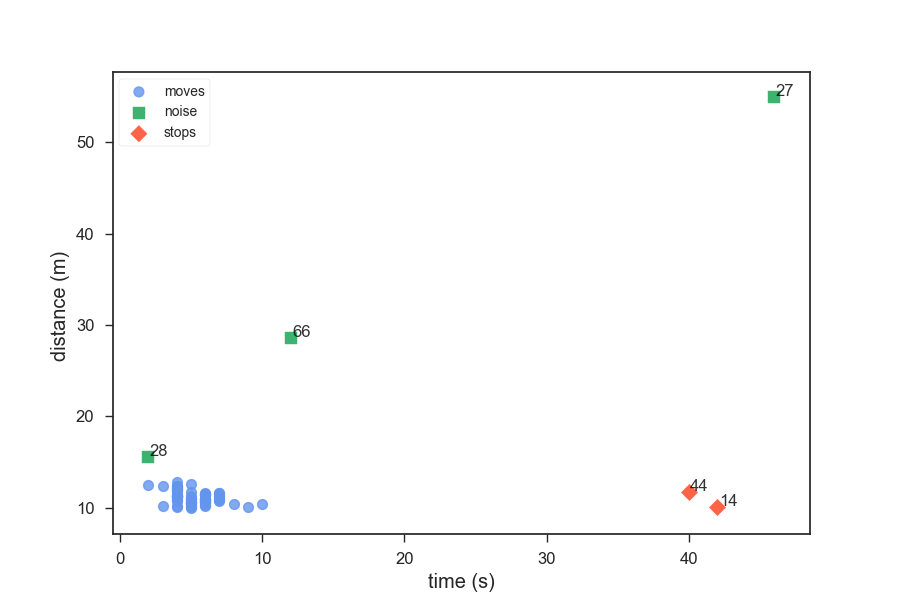

In [36]:
x_label = 'time (s)'
y_label = 'distance (m) '

x = df['time']
y = df['distance']
z = df['speed']

X = np.stack((x, y), axis=-1)

fig = plt.figure()
plt.xlabel(x_label)
plt.ylabel(y_label)
ax = fig.add_subplot(111)
plt.scatter(X[:,0], X[:,1], s=50, alpha=.8, color='cornflowerblue', lw=1, label='moves')

# plot noise
all_noise = np.array([])
for i in out:
    element = X[i]
    ax.annotate(df.iloc[i]['idx'], xy=(element[0]+0.1, element[1]+0.1), color='black', alpha=.8)
    all_noise = np.append(all_noise, [element[0], element[1]])
    
if len(all_noise) > 0:
    all_noise = np.reshape(all_noise, (-1, 2))
    plt.scatter(all_noise[:,0], all_noise[:,1], marker='s', s=70, color='mediumseagreen', label='noise')
#

#plot stops
x = df2['time']
y = df2['distance']
X = np.stack((x, y), axis=-1)

stops = np.array([])
for i, element in enumerate(X):
    if mz_time[i] > time_threshold and mz_speed[i] < -speed_threshold:
        ax.annotate(df2.iloc[i]['idx'], xy=(element[0]+0.1, element[1]+0.1), color='black', alpha=.8)
        stops = np.append(stops, [element[0], element[1]])

if len(stops) > 0:
    stops = np.reshape(stops, (-1, 2))
    plt.scatter(stops[:,0], stops[:,1], marker='D', s=70, color='tomato', label='stops')
#

plt.legend(frameon=True, loc=2);
plt.savefig('figures/msn-final.png')

<IPython.core.display.Javascript object>


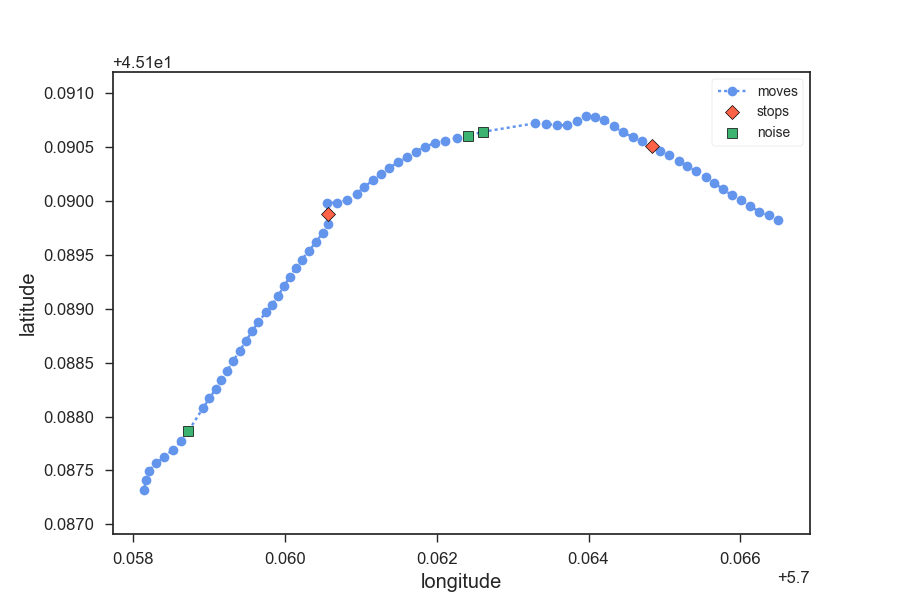

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlabel('longitude')
plt.ylabel('latitude')

xx = df.longitude
yy = df.latitude
plt.plot(xx, yy, 'o:', label='moves', color='cornflowerblue', ms=7, alpha=1)

stops_i = speed_time_intersection['idx'].values
xx = df.iloc[stops_i].longitude
yy = df.iloc[stops_i].latitude
plt.plot(xx, yy, 'D', label='stops', color='tomato', ms=7, alpha=1, mew=.5, mec='k')

xx = df.iloc[out].longitude
yy = df.iloc[out].latitude
plt.plot(xx, yy, 's', label='noise', color='mediumseagreen', ms=7, alpha=1, mew=.5, mec='k')

plt.legend(loc='best', frameon=True)

central_latitude = sum(plt.axes().get_ylim())/2.
mercator_aspect_ratio = 1/cos(radians(central_latitude))
plt.axes().set_aspect(mercator_aspect_ratio, adjustable='datalim')

#future work

from sklearn import linear_model, metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = mz_time
y = mz_speed
Xt = np.stack((x, y), axis=-1)

np.random.seed(42)

#X = np.random.normal(size=400)
#y = np.sin(X)
#Make sure that it X is 2D
X = X[:, np.newaxis]

#X_test = np.random.normal(size=200)
#y_test = np.sin(X_test)
#X_test = X_test[:, np.newaxis]

estimators = [('OLS', linear_model.LinearRegression()),
              ('Theil-Sen', linear_model.TheilSenRegressor(random_state=42)),
              ('RANSAC', linear_model.RANSACRegressor(random_state=42)), ]

x_plot = np.linspace(X.min(), X.max()*1.1)

plt.figure()
plt.plot(X[:, 0], y, 'ko', mew=1)

for name, estimator in estimators:
    model = make_pipeline(PolynomialFeatures(2), estimator)
    model.fit(X, y)
    #mse = metrics.mean_squared_error(model.predict(X_test), y_test)
    y_plot = model.predict(x_plot[:, np.newaxis])
    #plt.plot(x_plot, y_plot, label='%s: error = %.3f' % (name, mse))
    plt.plot(x_plot, y_plot)

#plt.legend(loc='best', frameon=True, title='Error: mean absolute deviation\n to non corrupt data')

#plt.xlim(min(X)*1.3, max(X)*1.3)
plt.ylim(min(y)*1.5, max(y)*1.5);

## Sliding Window

from itertools import islice
def n_grams(a, n):
    z = (islice(a, i, None) for i in range(n))
    return zip(*z)

window_size = 20

scores = {}
for i in df2.idx:
    scores.update({i: []})

for idxs, subseries in zip(n_grams(df2.idx, window_size), n_grams(j_time, window_size)):
    mzs = st.modified_zscore(subseries)
    for i, value in zip(idxs, mzs):
        scores[i].append(value)

for key, value in scores.items():
    if len(value) < window_size:
        missing = window_size - len(value)
        value.extend([None] * missing)
        scores.update({key: value})

mz_df = pnd.DataFrame(scores)
mz_df = mz_df.transpose()
mz_df = mz_df.set_index(df2.index)

stops_rmz = mz_df.loc[df.index[stop_i]]

plt.figure()
for stop in stops_rmz.iterrows():
    plt.plot(stop[1], 'o-')
#plt.plot(mz_time)
plt.plot(mz_df.iloc[30], 'o-', label='30')
plt.plot(mz_df.iloc[40], 'o-', label='40')
plt.plot(mz_df.iloc[50], 'o-', label='50')
plt.plot(mz_df.iloc[60], 'o-', label='60')
plt.plot(mz_df.iloc[70], 'o-', label='70')
#plt.plot(mz_df.iloc[80], label='80')
#plt.plot(mz_df.iloc[90], label='90')
plt.legend();

means = []
for stop in stops_rmz.iterrows():
    means.append(np.mean(stop[1]))
    
plt.figure()
sns.distplot(means, rug=True);
mz_means = st.modified_zscore(means)
mz_means_i = [i for i, mz in enumerate(mz_means) if abs(mz) > 3.5]

stops_rmz.iloc[mz_means_i]

## Create STEP episodes

In [38]:
stops_i

array([14, 44])

In [39]:
q = 'idx in {0}'.format(list(stops_i))
df.query(q)

,acceleration,angle,distance,elevation,heading,latitude,longitude,speed,time,timestamp,idx
2016-07-04 16:11:38,0.275688,177.366736,10.049018,216,298,45.190511,5.764833,0.239262,42,2016-07-04 16:11:38,14
2016-07-04 16:15:38,0.370802,177.174237,11.731872,213,174,45.189882,5.760566,0.293297,40,2016-07-04 16:15:38,44


In [40]:
out

array([27, 28, 66])

In [41]:
q = 'idx in {0}'.format(list(out))
df.query(q)

,acceleration,angle,distance,elevation,heading,latitude,longitude,speed,time,timestamp,idx
2016-07-04 16:13:29,3.290981,174.436696,54.960081,215,261,45.190644,5.762608,1.194783,46,2016-07-04 16:13:29,27
2016-07-04 16:13:31,-0.775425,177.916821,15.553499,214,255,45.190608,5.762417,7.776745,2,2016-07-04 16:13:31,28
2016-07-04 16:17:16,0.203644,177.046914,28.616599,216,213,45.187866,5.758729,2.384714,12,2016-07-04 16:17:16,66


In [42]:
outlier_intervals

[[27, 28], [66, 66]]

In [43]:
stop_i = speed_time_intersection['idx'].values
print(stop_i)

stop_intervals = util.get_interval_limits(stop_i)
print(stop_intervals)

[14 44]
[[14, 14], [44, 44]]


In [44]:
moves_i = np.linspace(0, len(df)-1, len(df), dtype=int)

to_concatenate = []
if len(out): to_concatenate.append(out)
if len(stops_i): to_concatenate.append(stops_i)
    
non_move_i = []
if len(to_concatenate): 
    non_move_i = np.concatenate(to_concatenate, 0)

moves_i = np.delete(moves_i, non_move_i)
move_intervals = util.get_interval_limits(moves_i, tolerance=0)

print(non_move_i)
print(move_intervals)

[27 28 66 14 44]
[[0, 13], [15, 26], [29, 43], [45, 65], [67, 73]]


In [45]:
EXAMPLE = Namespace('http://example.com/resource/')

raw = utility.create_raw_trajectory(gpx)
points_data = gpx.get_points_data()[1:] #the first point is also discarded when creating the dataframe df

In [46]:
def create_episodes(intervals, qualitative_description_str):
    eps = []
    
    qualitative_description = step.QualitativeDescription(qualitative_description_str)
    
    for interval in intervals:
        start_index = interval[0]
        end_index = interval[1]

        start_fix = raw.get_fix(points_data[start_index].point.time)
        
        #end_fix = None
        #if start_index != end_index:
        end_fix = raw.get_fix(points_data[end_index].point.time)
            
        st_extent = step.SpatiotemporalExtent(start_fix, end_fix)

        episode = step.Episode(st_extent, qualitative_description)

        eps.append(episode)
    
    return eps

In [47]:
foi_movestopnoise = step.FeatureOfInterest("MoveStopNoise")

noise_episodes = create_episodes(outlier_intervals, "Noise")
for eps in noise_episodes:
    foi_movestopnoise.add_episode(eps)
    
stop_episodes = create_episodes(stop_intervals, "Stop")
for eps in stop_episodes:
    foi_movestopnoise.add_episode(eps)
    
move_episodes = create_episodes(move_intervals, "Move")
for eps in move_episodes:
    foi_movestopnoise.add_episode(eps)

In [48]:
foi_movestopnoise

{ "FeatureOfInterest": { "label": "MoveStopNoise", "Episodes": [{ "Episode": { "semantic_description":{ "QualitativeDescription": { "description": "Noise"} }, "extent": [{ "SpatiotemporalExtent": { "start": { "Fix": { "Point": { "lat": "45.1906438907", "long": "5.7626078452", "elev": "276.1"}, "TimeInstant": { "in_datetime": "2016-07-04 16:13:29"}  } }, "end": { "Fix": { "Point": { "lat": "45.1906081393", "long": "5.762416588", "elev": "283.5"}, "TimeInstant": { "in_datetime": "2016-07-04 16:13:31"}  } }, "key_points": []} }], "relates_to": None } }, { "Episode": { "semantic_description":{ "QualitativeDescription": { "description": "Noise"} }, "extent": [{ "SpatiotemporalExtent": { "start": { "Fix": { "Point": { "lat": "45.1878663271", "long": "5.7587288363", "elev": "269.8"}, "TimeInstant": { "in_datetime": "2016-07-04 16:17:16"}  } }, "end": { "Fix": { "Point": { "lat": "45.1878663271", "long": "5.7587288363", "elev": "269.8"}, "TimeInstant": { "in_datetime": "2016-07-04 16:17:16"}  

triples = foi_movestopnoise.triplify()

g = Graph()
for triple in triples:
    g.add(triple)
    
g.serialize("stopmovenoise.rdf")

In [49]:
#loc = df.index.get_loc("2015-04-20 06:01:19")
#loc.start